<a href="https://colab.research.google.com/github/kabirodavies/data-project/blob/main/Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business problem overview

Churn rate is a vital metric to track for any OTT (over-the-top) service provider.

Churn rate describes the number of OTT subscribers that cancel their subscriptions over a fixed period.

For the business, a high OTT churn rate means: Reduced customer lifetime value (CLV) Increased customer acquisition costs (CAC) Essentially, your platform must work harder to acquire new customers and retain existing ones over time.

Types of OTT subscription churn
There are two types of churn rates: voluntary and involuntary.

Voluntary churn is when the customer intentionally cancels or downgrades their subscription.

Involuntary churn occurs when the subscription is canceled for reasons behold the subscribers control, like application error, internet buffering.

Users usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value users).

In churn prediction, we assume that there are three phases of customer lifecycle :

**The ‘good’ phase:** In this phase, the customer is happy with the service and behaves as usual.

**The ‘action’ phase:** The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point

**The ‘churn’ phase:** In this phase, the customer is said to have churned. You define churn based on this phase.

# Exporting required libraries

In [162]:
#Installing packages
!pip install lifetimes
!pip install lifelines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 349 kB 12.7 MB/s 
     |████████████████████████████████| 77 kB 4.9 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4049 sha256=cd32ea51db428335d48e851066151f434199a6faa6cbce95f3b966026ac82eeb
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.1.5

In [163]:
# Importing required libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, plot_confusion_matrix, plot_roc_curve, classification_report
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from imblearn.over_sampling import SMOTE
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.api as st
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

#EDA
from lifetimes.plotting import *
from lifetimes.utils import *
#Lifelines is a survival analysis package
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test   
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline

# Reading and understanding the data
**This dataset contains records of users over the duration of 77 days**

In [18]:
#Read Data
clean_data_url = 'https://raw.githubusercontent.com/kabirodavies/data-project/main/data.csv'
data = pd.read_csv(clean_data_url, encoding = 'utf8', index_col=0, parse_dates=['date'])
data.head()

,date,ip,app_name,app_ver,isp,country,connection_type,default_language,user_frequency,churn
0,2022-08-05,97.118.20.38,Aquarium TV,V_s5.1.9b,CenturyLink,US,Cable/DSL,English,1,Yes
1,2022-08-05,189.203.104.188,ADULTish,V_s5.1.9b,Totalplay,MX,Cable/DSL,English,1,Yes
2,2022-08-05,81.111.134.45,Aquarium TV,5.8.4,Virgin Media,GB,Cable/DSL,English,1,Yes
3,2022-08-05,36.68.10.202,Culture Forward TV,5.8.4,PT Telkom Indonesia,ID,Cable/DSL,English,1,Yes
4,2022-08-05,216.238.178.89,Aquarium TV,5.2.0,Auburn Essential Services,US,Cable/DSL,English,1,Yes


In [19]:
# Checking shape of dataframe (Check count of rows and columns)
data.shape

(4279, 10)

In [21]:
#Checking dataframe info
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4279 entries, 0 to 11879
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              4279 non-null   datetime64[ns]
 1   ip                4279 non-null   object        
 2   app_name          4279 non-null   object        
 3   app_ver           4279 non-null   object        
 4   isp               4279 non-null   object        
 5   country           4279 non-null   object        
 6   connection_type   4279 non-null   object        
 7   default_language  4279 non-null   object        
 8   user_frequency    4279 non-null   int64         
 9   churn             4279 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(8)
memory usage: 367.7+ KB


In [22]:
# checking column names
data.columns

Index(['date', 'ip', 'app_name', 'app_ver', 'isp', 'country', 'connection_type', 'default_language', 'user_frequency', 'churn'], dtype='object')

In [15]:
#Checking descriptive statistics
data.describe()

,date,ip,app_name,app_ver,isp,country,connection_type,default_language
count,4279,4279,4279,4279,4279,4279,4279,4279
unique,33,4165,97,34,1163,136,4,41
top,2022-09-14 00:00:00,176.112.65.246,Aquarium TV,5.8.82,Spectrum,US,Cable/DSL,English
freq,466,10,449,749,301,1426,3386,3763
first,2022-08-04 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2022-10-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Explaining dataset
**Note: This data has had some transformation done:**

1. Selecting a subset of columns important for this analysis that didn't have too much missing data.
2. Imputed the few missing records by mode.
3. Created new features from existing features (user_frequency and churn).  

**After eyeballing and exploring the data, we can categorize 10 different attributes into below categories:**

1. date : Period of user activity
2. ip : Unique identifier of each user
3. app_name : OTT channels
4. app_ver : Verion of platform 
5. isp : Internet Service Provider
6. country : Place of origin of user
7. connection_type : Internet connection type
8. default_language : Language used 
9. user_frequency : Number of times a user has visited
10. churn : "Yes" means customer churned, "No" means customer did not churn

**Assumptions**
1. A user having multiple sessions within a day, but for the scope of this analysis churn is users who never returned.

#Exploratory Data Analysis

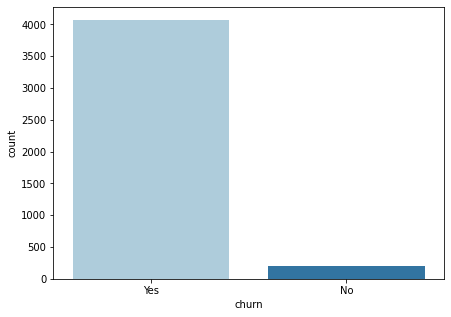

In [23]:
# Checking churn data
plt.figure(figsize= [7,5])
sns.countplot(data.churn, palette= 'Paired', label=[1,0])
plt.show()

**The plot above shows a huge amount of users visited only once, thus churned.**

In [30]:
# Columns to analyze
char_columns_to_analyze= ['app_name', 'isp', 'country', 'connection_type', 'default_language']

**To further understand users, I am going to check for the following:**

*   **Frequency: represents count of times a user visits.**
*   **Recency: represents time in days since a user last visited.**
*   **T: represents time in days (age) since a user last visited from the last day.**






In [31]:
#Check the Last app visit date
last_visit_date = data['date'].dt.date.max()
print(last_visit_date)

2022-10-20


In [35]:

#Built-in utility functions from lifetimes package to transform the data (one row per visit) into summary data (frequency, recency, and age(T))
data_df = summary_data_from_transaction_data(data, 'ip', 'date', observation_period_end='2022-10-20')
data_df = data_df.reset_index()
data_df.head()

,ip,frequency,recency,T
0,1.123.101.22,0.0,0.0,0.0
1,1.123.147.77,0.0,0.0,24.0
2,1.147.96.230,0.0,0.0,13.0
3,1.152.109.42,0.0,0.0,22.0
4,1.157.5.57,0.0,0.0,0.0


**The plot below just shows that user frequency is quite low with majority of users visiting only once**

count    4165.000000
mean        0.012485
std         0.121382
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: frequency, dtype: float64
---------------------------------------
Percentage of users visiting only once: 98.85 %


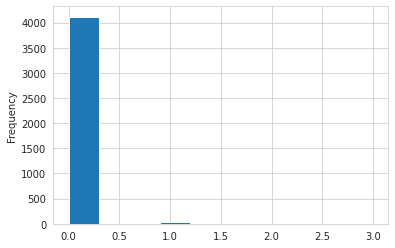

In [36]:
%matplotlib inline
#Create histogram to find out how many customers purchased item only once.
data_df['frequency'].plot(kind='hist', bins=10)
print(data_df['frequency'].describe())
print("---------------------------------------")
one_time_visitors = round(sum(data_df['frequency'] == 0)/float(len(data_df))*(100),2)
print("Percentage of users visiting only once:", one_time_visitors ,"%")

**The plot (heatmap) below tells the story of who the most valiable users are. They are those who have visited about three times in the last 70 or so days.**

**How to understand this plot: We care more about customers who have been with us since day one than someone who shows up once in six months.**

**This plot tells us that we need to reduce the duration (recency) of the loyal users**

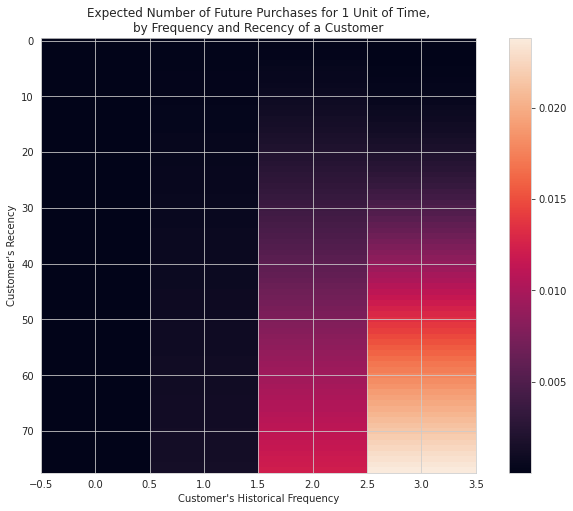

In [38]:
#Visualizing our frequency/recency matrix
%matplotlib inline
import matplotlib.pyplot as plt
from lifetimes.plotting import plot_frequency_recency_matrix
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

**The plot below shows that the most alive users are those who visited once. Users we care about are not very much alive as shown by the heatmap**

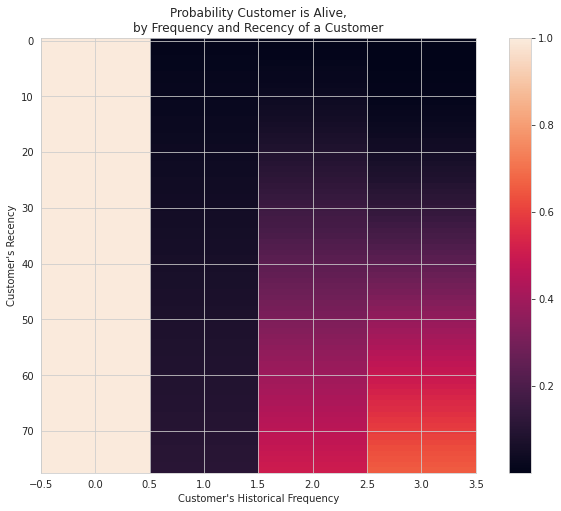

In [39]:
#predict if the customers are surely alive:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

**This is a distribution of user visits on the different channels**

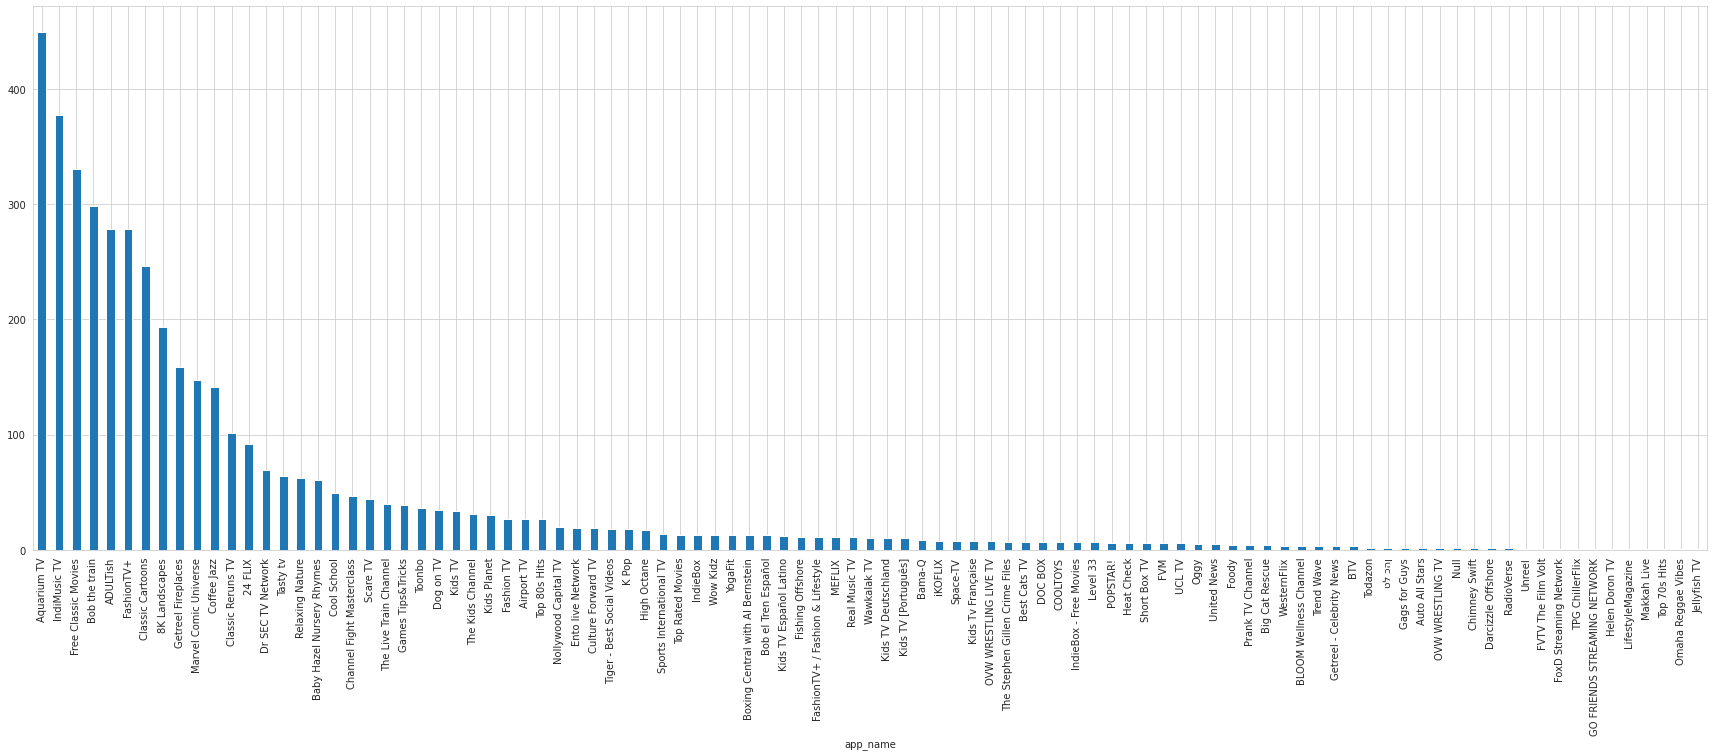

In [44]:
#check user frequency of users 
#calculate count of values by group
df_name_freq = data.groupby(['app_name'])['ip'].count()

#create bar plot by group
df_name_freq = df_name_freq.sort_values(ascending=False)
df_name_freq.plot(kind='bar',  figsize=(30, 10))

**This is a distribution user churn grouped by date**

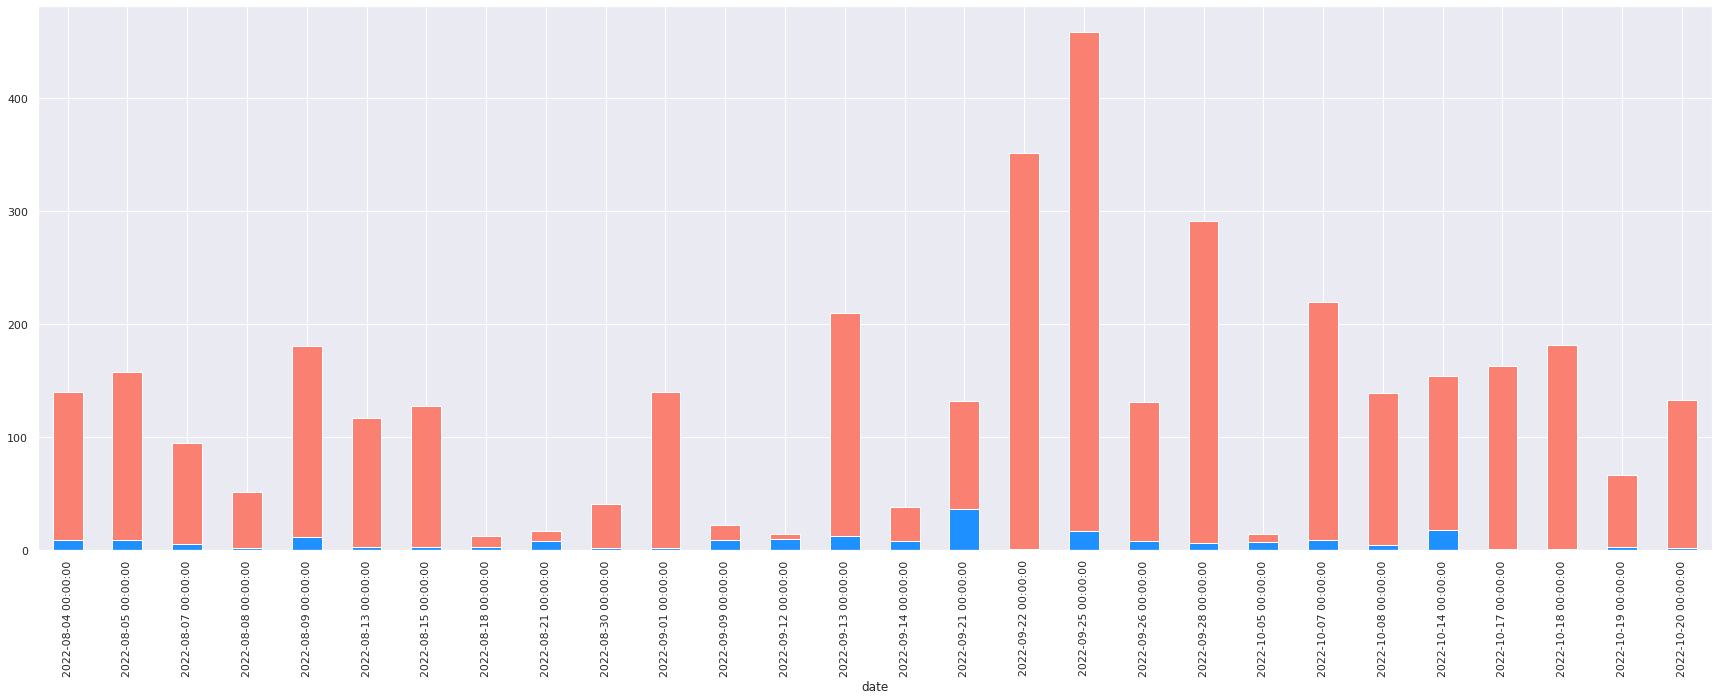

In [120]:
churned = data[data['churn']=='Yes']
not_churned = data[data['churn']=='No']

freq_c = churned.groupby(['date'])['churn'].size()
freq_nc = not_churned.groupby(['date'])['churn'].size()

#create bar plot by group
freq_c.plot(kind='bar',  color='salmon', figsize=(30, 10))
freq_nc.plot(kind='bar', color='dodgerblue', figsize=(30, 10))

In [126]:
def stacked_plot(df, group, target):
    """
    Function to generate a stacked plots between two variables
    """
    fig, ax = plt.subplots(figsize = (10,70))
    temp_df = (df.groupby([group, target]).size()/df.groupby(group)[target].count()).reset_index().pivot(columns=target, index=group, values=0)
    temp_df.plot(kind='barh', stacked=True, grid=False, ax = ax, color = ["dodgerblue", "salmon"])
    ax.xaxis.set_tick_params(rotation=0)
    ax.set_xlabel(group)
    ax.set_ylabel('Churn Percentage')

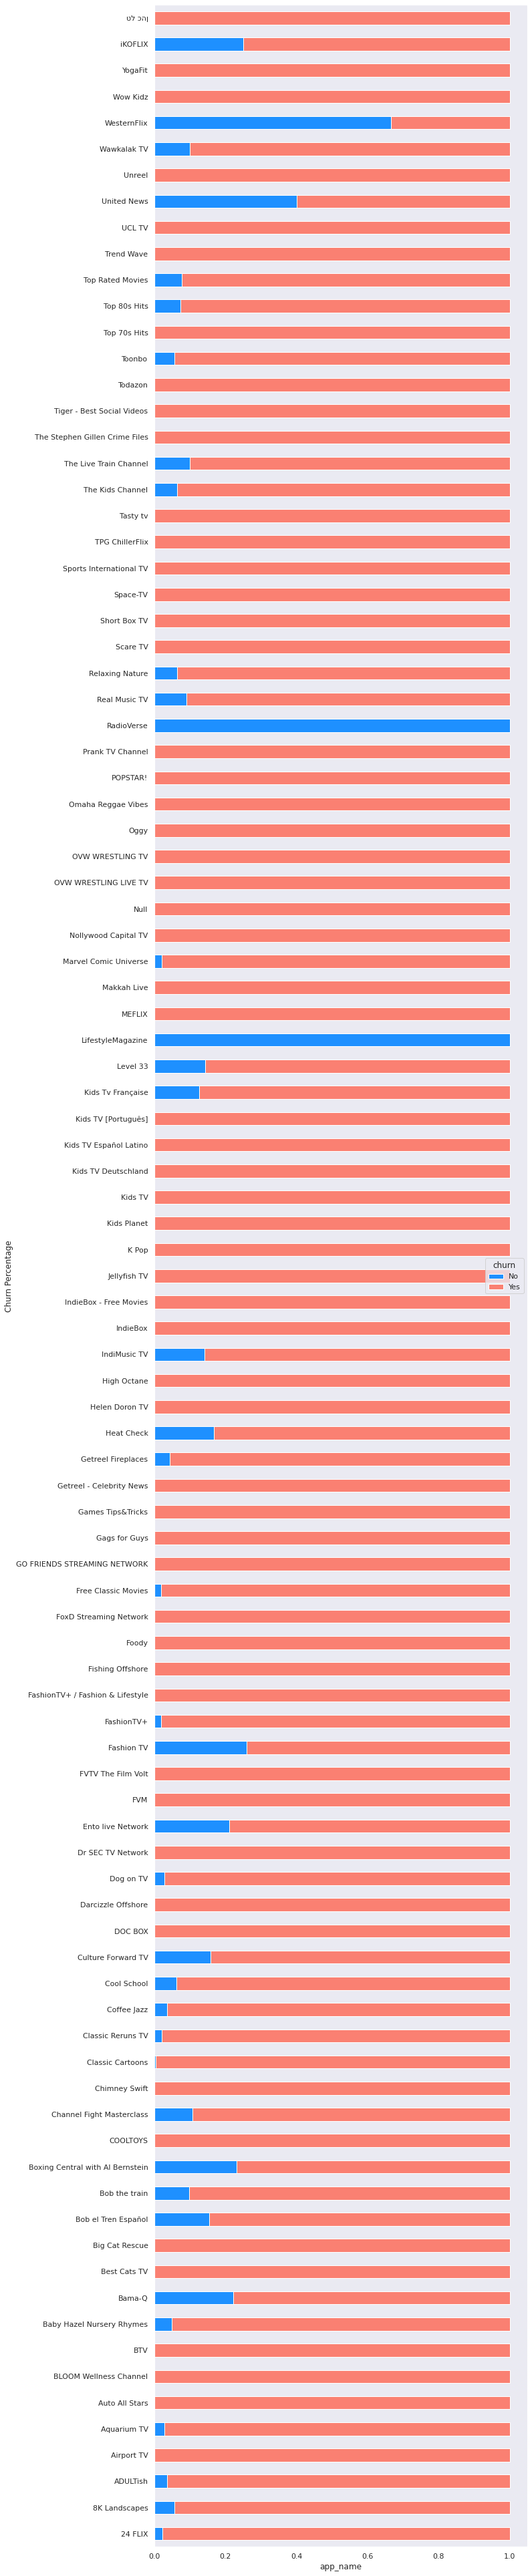

In [127]:
stacked_plot(data, "app_name", "churn")

**Apps with highest number of users visits like Aquarium TV don't necessarily  **

**Language VS Churn**

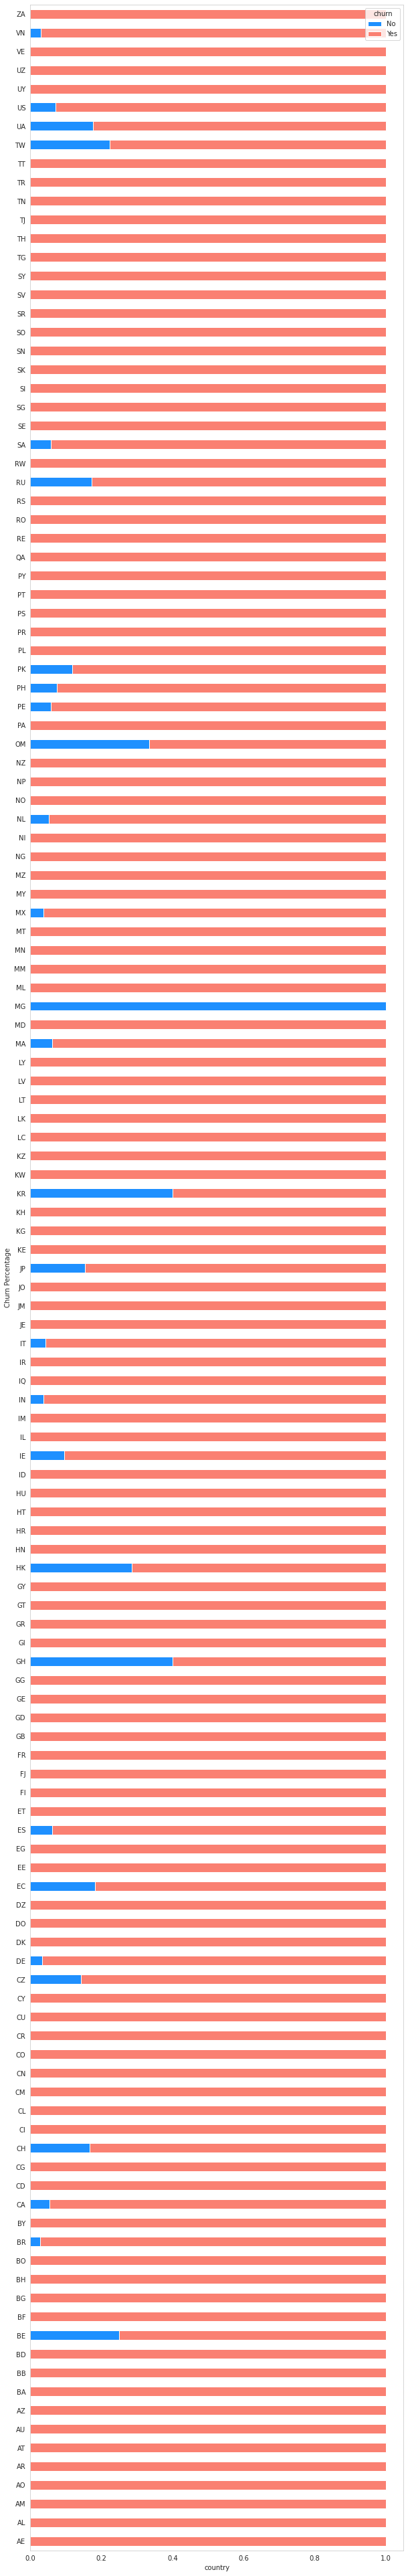

In [91]:
stacked_plot(data, "country", "churn")

**Country VS Churn**

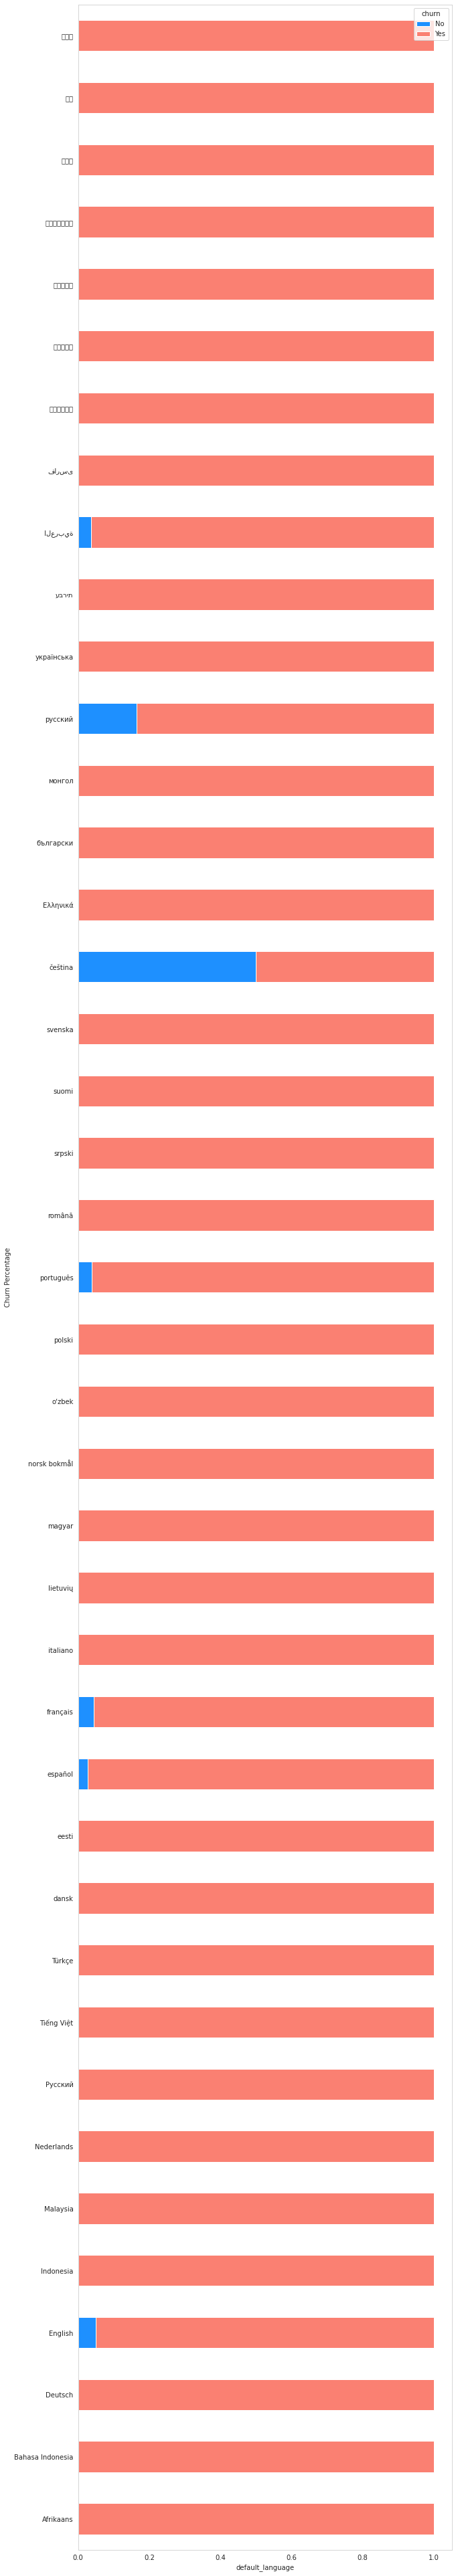

In [93]:
stacked_plot(data, "default_language", "churn")

In [115]:
def stacked_plot_conn(df, group, target):
    """
    Function to generate a stacked plots between two variables
    """
    fig, ax = plt.subplots(figsize = (15,5))
    temp_df = (df.groupby([group, target]).size()/df.groupby(group)[target].count()).reset_index().pivot(columns=target, index=group, values=0)
    temp_df.plot(kind='bar', stacked=True, grid=False, ax = ax, color = ["dodgerblue", "salmon"])
    ax.xaxis.set_tick_params(rotation=0)
    ax.set_xlabel(group)
    ax.set_ylabel('Churn Percentage')

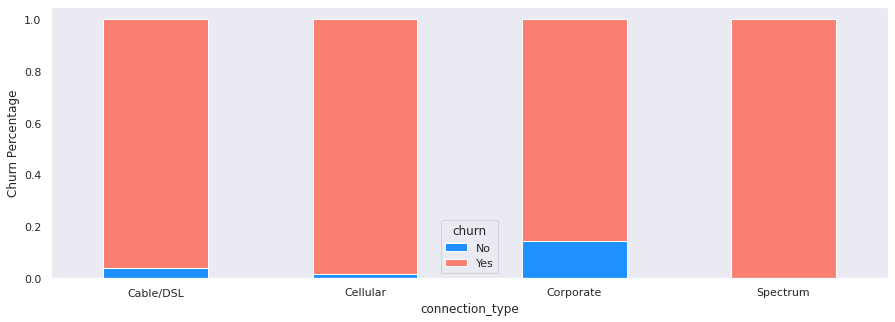

In [116]:
stacked_plot_conn(data, "connection_type", "churn")

In [147]:
# Check the figures for both churn and not churn
conn_c = churned.groupby(['connection_type'])['churn'].size()
conn_nc = not_churned.groupby(['connection_type'])['churn'].size()

print("Churned")
print(conn_c)

print("Not churned")
print(conn_nc)

Churned
connection_type
Cable/DSL    3251
Cellular      353
Corporate     407
Spectrum       59
Name: churn, dtype: int64
Not churned
connection_type
Cable/DSL    135
Cellular       6
Corporate     68
Name: churn, dtype: int64


**Seems like majority of users user Corporate connection type **


**ISP VS Churn**

In [124]:
def stacked_plot_isp(df, group, target):
    """
    Function to generate a stacked plots between two variables
    """
    fig, ax = plt.subplots(figsize = (10,300))
    temp_df = (df.groupby([group, target]).size()/df.groupby(group)[target].count()).reset_index().pivot(columns=target, index=group, values=0)
    temp_df.plot(kind='barh', stacked=True, grid=False, ax = ax, color = ["dodgerblue", "salmon"])
    ax.xaxis.set_tick_params(rotation=0)
    ax.set_xlabel(group)
    ax.set_ylabel('Churn Percentage')

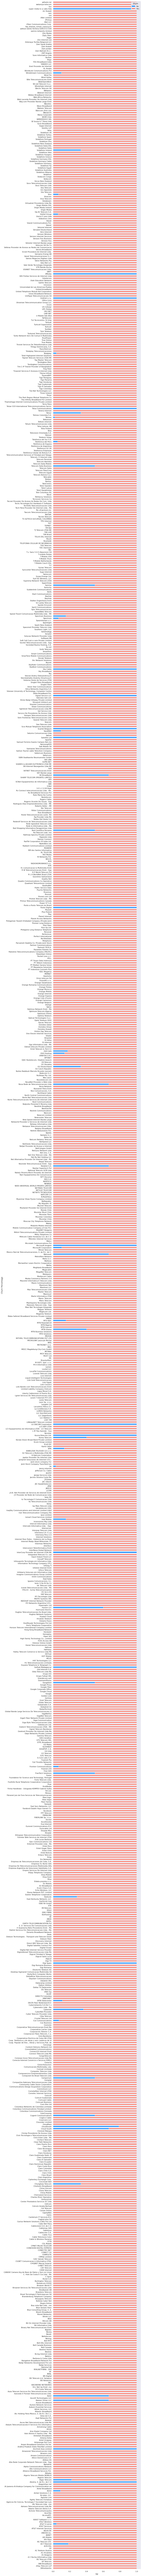

In [125]:
stacked_plot_isp(data, "isp", "churn")


#Survival Analysis

**Here, Churn is an event which indicates whether customer exited or not. Tenure(T) shows how long customer remained in our service. Both of these variables are very important for customer survival analysis.**

In [208]:
data_df.head()

,ip,frequency,recency,T
0,1.123.101.22,0.0,0.0,0.0
1,1.123.147.77,0.0,0.0,24.0
2,1.147.96.230,0.0,0.0,13.0
3,1.152.109.42,0.0,0.0,22.0
4,1.157.5.57,0.0,0.0,0.0


In [214]:
data.head()

,date,ip,app_name,app_ver,isp,country,connection_type,default_language,user_frequency,churn
0,2022-08-05,97.118.20.38,Aquarium TV,V_s5.1.9b,CenturyLink,US,Cable,English,1,Yes
1,2022-08-05,189.203.104.188,ADULTish,V_s5.1.9b,Totalplay,MX,Cable,English,1,Yes
2,2022-08-05,81.111.134.45,Aquarium TV,5.8.4,Virgin Media,GB,Cable,English,1,Yes
3,2022-08-05,36.68.10.202,Culture Forward TV,5.8.4,PT Telkom Indonesia,ID,Cable,English,1,Yes
4,2022-08-05,216.238.178.89,Aquarium TV,5.2.0,Auburn Essential Services,US,Cable,English,1,Yes


In [213]:
# Renaming connection_type "Cable/DSL"
data['connection_type'].replace(to_replace='Cable/DSL', value= 'Cable', inplace=True)

In [215]:
df = pd.merge(data, data_df,on='ip',how='left')
df.head()


,date,ip,app_name,app_ver,isp,country,connection_type,default_language,user_frequency,churn,frequency,recency,T
0,2022-08-05,97.118.20.38,Aquarium TV,V_s5.1.9b,CenturyLink,US,Cable,English,1,Yes,0.0,0.0,76.0
1,2022-08-05,189.203.104.188,ADULTish,V_s5.1.9b,Totalplay,MX,Cable,English,1,Yes,0.0,0.0,76.0
2,2022-08-05,81.111.134.45,Aquarium TV,5.8.4,Virgin Media,GB,Cable,English,1,Yes,0.0,0.0,76.0
3,2022-08-05,36.68.10.202,Culture Forward TV,5.8.4,PT Telkom Indonesia,ID,Cable,English,1,Yes,0.0,0.0,76.0
4,2022-08-05,216.238.178.89,Aquarium TV,5.2.0,Auburn Essential Services,US,Cable,English,1,Yes,0.0,0.0,76.0


Here, Churn is an event which indicates whether customer exited or not. Tenure shows how long customer remained in our service. Both of these variables are very important for customer survival analysis.

In [216]:
df.churn = labelencoder.fit_transform(df.churn)
df.churn.value_counts()

1    4070
0     209
Name: churn, dtype: int64

In [217]:
eventvar = df['churn']
timevar = df['T']

*For the analysis, I will need to create dummy variables for all categorical variables.*



In [222]:
categorical = ['connection_type', 'app_name', 'isp', 'country', 'app_ver', 'default_language']

survivaldata = pd.get_dummies(df, columns = categorical, drop_first= True)
survivaldata.head()

,date,ip,user_frequency,churn,frequency,recency,T,connection_type_Cellular,connection_type_Corporate,connection_type_Spectrum,app_name_8K Landscapes,app_name_ADULTish,app_name_Airport TV,app_name_Aquarium TV,app_name_Auto All Stars,app_name_BLOOM Wellness Channel,app_name_BTV,app_name_Baby Hazel Nursery Rhymes,app_name_Bama-Q,app_name_Best Cats TV,app_name_Big Cat Rescue,app_name_Bob el Tren Español,app_name_Bob the train,app_name_Boxing Central with Al Bernstein,app_name_COOLTOYS,app_name_Channel Fight Masterclass,app_name_Chimney Swift,app_name_Classic Cartoons,app_name_Classic Reruns TV,app_name_Coffee Jazz,app_name_Cool School,app_name_Culture Forward TV,app_name_DOC BOX,app_name_Darcizzle Offshore,app_name_Dog on TV,app_name_Dr SEC TV Network,app_name_Ento live Network,app_name_FVM,app_name_FVTV The Film Volt,app_name_Fashion TV,app_name_FashionTV+,app_name_FashionTV+ / Fashion & Lifestyle,app_name_Fishing Offshore,app_name_Foody,app_name_FoxD Streaming Network,app_name_Free Classic Movies,app_name_GO FRIENDS STREAMING NETWORK,app_name_Gags for Guys,app_name_Games Tips&Tricks,app_name_Getreel - Celebrity News,app_name_Getreel Fireplaces,app_name_Heat Check,app_name_Helen Doron TV,app_name_High Octane,app_name_IndiMusic TV,app_name_IndieBox,app_name_IndieBox - Free Movies,app_name_Jellyfish TV,app_name_K Pop,app_name_Kids Planet,app_name_Kids TV,app_name_Kids TV Deutschland,app_name_Kids TV Español Latino,app_name_Kids TV [Português],app_name_Kids Tv Française,app_name_Level 33,app_name_LifestyleMagazine,app_name_MEFLIX,app_name_Makkah Live,app_name_Marvel Comic Universe,app_name_Nollywood Capital TV,app_name_Null,app_name_OVW WRESTLING LIVE TV,app_name_OVW WRESTLING TV,app_name_Oggy,app_name_Omaha Reggae Vibes,app_name_POPSTAR!,app_name_Prank TV Channel,app_name_RadioVerse,app_name_Real Music TV,app_name_Relaxing Nature,app_name_Scare TV,app_name_Short Box TV,app_name_Space-TV,app_name_Sports International TV,app_name_TPG ChillerFlix,app_name_Tasty tv,app_name_The Kids Channel,app_name_The Live Train Channel,app_name_The Stephen Gillen Crime Files,app_name_Tiger - Best Social Videos,app_name_Todazon,app_name_Toonbo,app_name_Top 70s Hits,app_name_Top 80s Hits,app_name_Top Rated Movies,app_name_Trend Wave,app_name_UCL TV,app_name_United News,app_name_Unreel,app_name_Wawkalak TV,app_name_WesternFlix,app_name_Wow Kidz,app_name_YogaFit,app_name_iKOFLIX,app_name_טל כהן,isp_2Day Telecom LLP,isp_3BB Broadband,isp_6P Telecom,isp_8G Telecom LTDA,isp_A C Rocha Informatica Ltda,isp_A1 Bulgaria,isp_A1 Hrvatska,isp_A1 Telekom Austria,isp_A3,isp_ACN DSL,isp_ACT Fibernet,isp_AG Telecom LTD.,isp_AIS Fibre,isp_AIS Mobile,isp_AKNET,isp_ANEXIA Inc.,isp_AQUA-DE,isp_AT&T Internet Services,isp_AT&T Services,isp_AT&T U-verse,isp_AT&T Wireless,isp_AVAST Software s.r.o.,isp_AXES,isp_AccessATC,isp_AcenTek,isp_Activex Telecomunicações,isp_Adamo Telecom Iberia S.A.,isp_Adriano Telecomunicacoes Ltda Me,isp_Afs Telecom Ltda. -me,"isp_Agencia De Ciencia, Tecnologia Y Sociedad San Luis",isp_Agility Telecom Fortaleza,isp_Agreste Link,"isp_Air-pipe, LLC.",isp_Airtek Solutions C.A.,isp_Airtel,isp_Airtel Broadband,isp_Al-Jazeera Al-Arabiya Company for Communication an,isp_Alagoinhas net,"isp_Alestra, S. de R.L. de C.V.",isp_Algar Telecom,isp_Algerie Telecom,isp_Algerie Telecom Mobile MOBILIS,isp_Alibaba,isp_Alliance Broadband Services Pvt.,isp_Allo Communications LLC,isp_Alpha Communications Network,isp_Alphalink,isp_Alta Rede Corporate Network Telecom Ltda - Epp,isp_Altibox AS,isp_Altice Dominicana S.A.,isp_Amara Communications,isp_Amazon.com,isp_Amazonet Telecomunicacoes Ltda,isp_Anchnet Asia Limited,isp_Andhra Pradesh State FiberNet Limited,isp_Anjani Broadband Solutions Pvt.ltd.,isp_Antaranga Dot Com,isp_Antel Uruguay,isp_Antena Delta,isp_Antietam Broadband,isp_Aoki Almino E Santos Ltda - Me,isp_Aria Shatel Company Ltd,isp_Arlink,isp_Armstrong Cable,isp_Asbyte Telecomunicacoes E Servicos Em Informatica,isp_Asces Net Telecomunicacao Ltda Me,isp_Asianet,is

We need to drop variables such as ip, tenure(T), Churn as they are not needed in survival data. Also, we need to add constant for survival analysis.



In [223]:
survivaldata.drop(['date', 'user_frequency', 'ip', 'T', 'churn'], axis = 1, inplace= True)
survivaldata = st.add_constant(survivaldata, prepend=False)
survivaldata.head()

,frequency,recency,connection_type_Cellular,connection_type_Corporate,connection_type_Spectrum,app_name_8K Landscapes,app_name_ADULTish,app_name_Airport TV,app_name_Aquarium TV,app_name_Auto All Stars,app_name_BLOOM Wellness Channel,app_name_BTV,app_name_Baby Hazel Nursery Rhymes,app_name_Bama-Q,app_name_Best Cats TV,app_name_Big Cat Rescue,app_name_Bob el Tren Español,app_name_Bob the train,app_name_Boxing Central with Al Bernstein,app_name_COOLTOYS,app_name_Channel Fight Masterclass,app_name_Chimney Swift,app_name_Classic Cartoons,app_name_Classic Reruns TV,app_name_Coffee Jazz,app_name_Cool School,app_name_Culture Forward TV,app_name_DOC BOX,app_name_Darcizzle Offshore,app_name_Dog on TV,app_name_Dr SEC TV Network,app_name_Ento live Network,app_name_FVM,app_name_FVTV The Film Volt,app_name_Fashion TV,app_name_FashionTV+,app_name_FashionTV+ / Fashion & Lifestyle,app_name_Fishing Offshore,app_name_Foody,app_name_FoxD Streaming Network,app_name_Free Classic Movies,app_name_GO FRIENDS STREAMING NETWORK,app_name_Gags for Guys,app_name_Games Tips&Tricks,app_name_Getreel - Celebrity News,app_name_Getreel Fireplaces,app_name_Heat Check,app_name_Helen Doron TV,app_name_High Octane,app_name_IndiMusic TV,app_name_IndieBox,app_name_IndieBox - Free Movies,app_name_Jellyfish TV,app_name_K Pop,app_name_Kids Planet,app_name_Kids TV,app_name_Kids TV Deutschland,app_name_Kids TV Español Latino,app_name_Kids TV [Português],app_name_Kids Tv Française,app_name_Level 33,app_name_LifestyleMagazine,app_name_MEFLIX,app_name_Makkah Live,app_name_Marvel Comic Universe,app_name_Nollywood Capital TV,app_name_Null,app_name_OVW WRESTLING LIVE TV,app_name_OVW WRESTLING TV,app_name_Oggy,app_name_Omaha Reggae Vibes,app_name_POPSTAR!,app_name_Prank TV Channel,app_name_RadioVerse,app_name_Real Music TV,app_name_Relaxing Nature,app_name_Scare TV,app_name_Short Box TV,app_name_Space-TV,app_name_Sports International TV,app_name_TPG ChillerFlix,app_name_Tasty tv,app_name_The Kids Channel,app_name_The Live Train Channel,app_name_The Stephen Gillen Crime Files,app_name_Tiger - Best Social Videos,app_name_Todazon,app_name_Toonbo,app_name_Top 70s Hits,app_name_Top 80s Hits,app_name_Top Rated Movies,app_name_Trend Wave,app_name_UCL TV,app_name_United News,app_name_Unreel,app_name_Wawkalak TV,app_name_WesternFlix,app_name_Wow Kidz,app_name_YogaFit,app_name_iKOFLIX,app_name_טל כהן,isp_2Day Telecom LLP,isp_3BB Broadband,isp_6P Telecom,isp_8G Telecom LTDA,isp_A C Rocha Informatica Ltda,isp_A1 Bulgaria,isp_A1 Hrvatska,isp_A1 Telekom Austria,isp_A3,isp_ACN DSL,isp_ACT Fibernet,isp_AG Telecom LTD.,isp_AIS Fibre,isp_AIS Mobile,isp_AKNET,isp_ANEXIA Inc.,isp_AQUA-DE,isp_AT&T Internet Services,isp_AT&T Services,isp_AT&T U-verse,isp_AT&T Wireless,isp_AVAST Software s.r.o.,isp_AXES,isp_AccessATC,isp_AcenTek,isp_Activex Telecomunicações,isp_Adamo Telecom Iberia S.A.,isp_Adriano Telecomunicacoes Ltda Me,isp_Afs Telecom Ltda. -me,"isp_Agencia De Ciencia, Tecnologia Y Sociedad San Luis",isp_Agility Telecom Fortaleza,isp_Agreste Link,"isp_Air-pipe, LLC.",isp_Airtek Solutions C.A.,isp_Airtel,isp_Airtel Broadband,isp_Al-Jazeera Al-Arabiya Company for Communication an,isp_Alagoinhas net,"isp_Alestra, S. de R.L. de C.V.",isp_Algar Telecom,isp_Algerie Telecom,isp_Algerie Telecom Mobile MOBILIS,isp_Alibaba,isp_Alliance Broadband Services Pvt.,isp_Allo Communications LLC,isp_Alpha Communications Network,isp_Alphalink,isp_Alta Rede Corporate Network Telecom Ltda - Epp,isp_Altibox AS,isp_Altice Dominicana S.A.,isp_Amara Communications,isp_Amazon.com,isp_Amazonet Telecomunicacoes Ltda,isp_Anchnet Asia Limited,isp_Andhra Pradesh State FiberNet Limited,isp_Anjani Broadband Solutions Pvt.ltd.,isp_Antaranga Dot Com,isp_Antel Uruguay,isp_Antena Delta,isp_Antietam Broadband,isp_Aoki Almino E Santos Ltda - Me,isp_Aria Shatel Company Ltd,isp_Arlink,isp_Armstrong Cable,isp_Asbyte Telecomunicacoes E Servicos Em Informatica,isp_Asces Net Telecomunicacao Ltda Me,isp_Asianet,isp_Aspt Networks Pvt,isp_Asta-ne

**Kaplan-Meier Curve**

*   **The Kaplan-Meier method calculates the probability of survival**

*  **Note that this method does not use any parameters, it only depends on the data on time and censoring.**







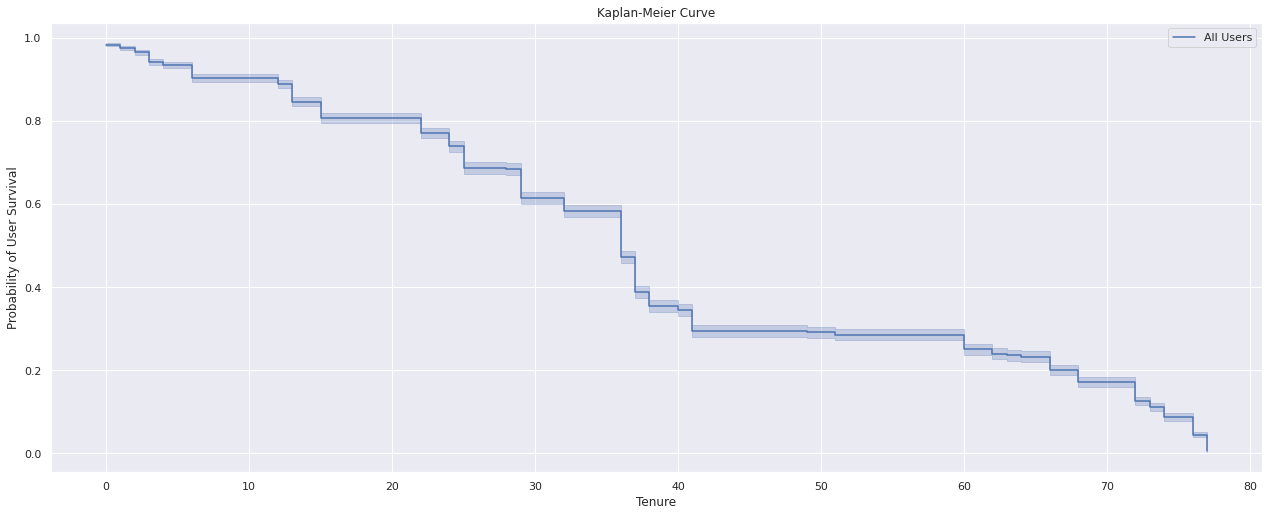

In [224]:
#Create a KaplanMeier object, imported from lifelines
kmf = KaplanMeierFitter()
#Calculate the K-M curve for all groups
kmf.fit(timevar,event_observed = eventvar,label = "All Users")
#Plot the curve and assign labels
kmf.plot()
plt.ylabel('Probability of User Survival')
plt.xlabel('Tenure')
plt.title('Kaplan-Meier Curve');

**As we can see, there is a sudden drop in the starting which says that after one tenure only users starts churning rapidly and after that churning rate decreases. To deal with that we can consider recommeding similar content to the user that to keep them intrested**

In [183]:
df['connection_type'].value_counts()

Cable/DSL    3386
Corporate     475
Cellular      359
Spectrum       59
Name: connection_type, dtype: int64

# Customer Lifetime Value

To user customer lifetime value, I would multiply the Monthly charges inform of ad revenue and the expected life time of the customer.